In this tutorial, we will learn how to use `snntorch` to:
* convert datasets to spiking datasets,
* how to visualize them,
* and how to generate random spike trains.

# SETTING UP THE MNIST DATASET
## 1.1 IMPORT PACKAGES

In [3]:
import torch
import snntorch as snn

In [6]:
# Training parameters
batch_size = 128
data_path = "/tmp/data/mnist"
num_classes = 10 # MNIST has 10 classes
input_size = (28, 28)
# Torch variables:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

## 1.2 DOWNLOAD DATASET

In [7]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0, ), (1 ,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(data_path, train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:52<00:00, 187635.18it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 146629.77it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:07<00:00, 209094.90it/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 15119467.28it/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



## 1.3 CREATE DATALOADERS


In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

# 2. SPIKE ENCODING
SNNs are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset. To use it with SNNs, we need to convert each image into a spike train of sequence length `num_steps`. Each pixel will be encoded as a spike train, where the properties of the spike train will depend on the pixel value. 

There are three main ways to encode the pixel values into spike trains:
1. **Rate coding**: uses the input feauters to determine the spiking **frequency**.
2. **Latency coding**: uses the input features to determine the spike **timing**.
3. **Delta coding**: uses the temporal **change** of input features to generate spikes.


## 2.1 RATE CODING
Each **normalized** input feature $X_{ij}$ is used as the **probability** a spike occurs at any given time step, returning a rate-coded value $R_{ij}$ This is then treated as the probability in a **Bernoulli** distribution $R_{ij} \sim Bernoulli(n, p)$, where $n=1$ is the number of trials and $p$ is the probability of success $X_{ij}$. As  `num_steps` $\rightarrow$ $\infty$, the proportion of spikes will converge to the original value of $X_{ij}$, thus encoding the normalized pixel value as a spike train. 

In [14]:
num_steps = 10  # Number of time steps for encoding
normalized_pixel_value = 0.7  # Example normalized pixel value (between 0 and 1)
raw_vector = torch.ones(num_steps)*normalized_pixel_value

rate_coded_vector = torch.bernoulli(raw_vector).to(device=device, dtype=dtype)
print(f"conveted vector: {rate_coded_vector}")
print(f"The output spiking rate is: {rate_coded_vector.sum()/num_steps*100:.2f}% of the time")

conveted vector: tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], device='cuda:0')
The output spiking rate is: 90.00% of the time


In [15]:
# increase the number of steps to see how the output changes
num_steps = 100  # Number of time steps for encoding
normalized_pixel_value = 0.7  # Example normalized pixel value (between 0 and 1)
raw_vector = torch.ones(num_steps)*normalized_pixel_value

rate_coded_vector = torch.bernoulli(raw_vector).to(device=device, dtype=dtype)
print(f"conveted vector: {rate_coded_vector}")
print(f"The output spiking rate is: {rate_coded_vector.sum()/num_steps*100:.2f}% of the time")

conveted vector: tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0')
The output spiking rate is: 71.00% of the time


Now lets generate the same rate-coding vector, with native snnTorch functions, under `spikegen` module. 
We are going to load a batch of images, and then encode each pixel value as a spike train using the `rate` function.

In [16]:
from snntorch import spikegen

data = iter(train_loader)
data_it, target_it = next(data)

spike_data = spikegen.rate(data_it, num_steps=num_steps)

print(f"spike_data shape: {spike_data.shape}")

spike_data shape: torch.Size([100, 128, 1, 28, 28])


**Pay attention: The first dimension of the spike_data tensor is sequence length, and the second dimension is batch size [TxBx1x28x28].**

## 2.2 VISUALIZING SPIKE DATA

### 2.2.1 ANIMATION

In [18]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [35]:
spike_data_sample = spike_data[:,0,0]
print(f"spike_data_sample shape: {spike_data_sample.shape}")

spike_data_sample shape: torch.Size([100, 28, 28])


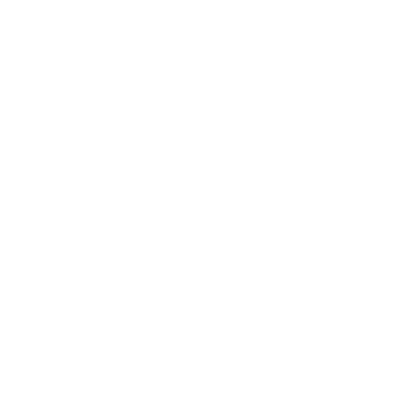

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())  # Display the animation in Jupyter Notebook

In [39]:
print(f"The corresponding label is: {target_it[0].item()}")

The corresponding label is: 9


MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do the againg but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here we will reduce spiking probablity by 25%, which translates frequency reduction of 25%.

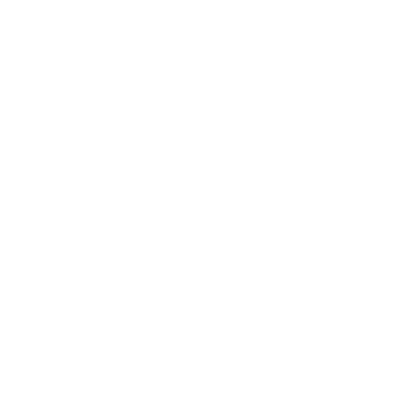

In [40]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:,0,0]
fig, ax = plt.subplots(figsize=(10, 5))
anim2 = splt.animator(spike_data_sample2, fig, ax)
HTML(anim2.to_html5_video())  # Display the animation in Jupyter Notebook

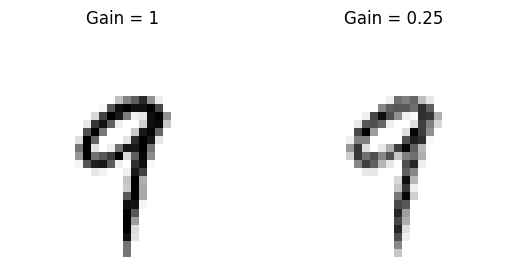

In [41]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()


### 2.2.2 RASTER PLOTS
Raster plots are a common way to visualize spike trains. They show the time of each spike for each neuron in a raster format, where each row represents a neuron and each dot represents a spike. To visualize the data as a raster plot, we are going to reshape the data into a 2-D tensor, where the 'time' is the first dimension.

spike_data_sample2 shape: torch.Size([100, 784])


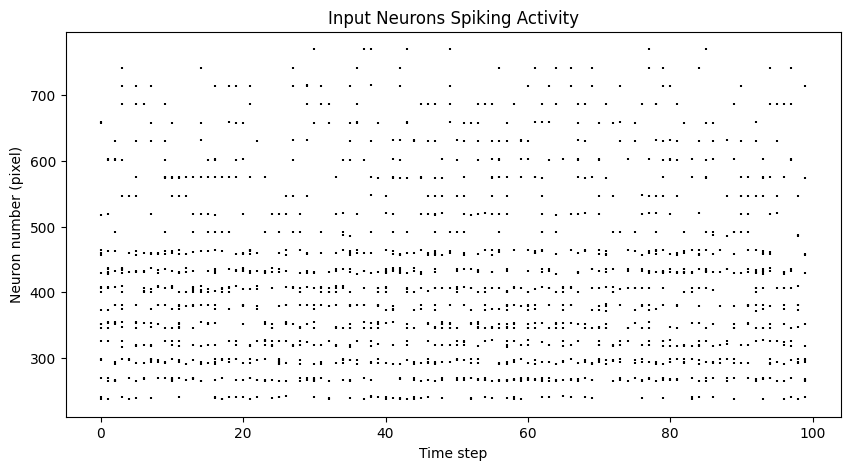

In [ ]:
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))
print(f"spike_data_sample2 shape: {spike_data_sample2.shape}")

# raster plot
fig = plt.figure(facecolor='w', figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax=ax, s=1.5, c="black")
plt.title("Input Neurons Spiking Activity")
plt.xlabel("Time step")
plt.ylabel("Neuron number (pixel)")
plt.show()

The following code shows how to index into one single neuron. 

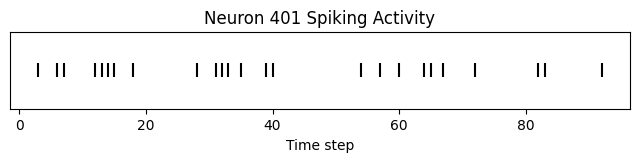

In [50]:
idx = 401

fig = plt.figure(facecolor='w', figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample2[:, idx].unsqueeze(1), ax=ax, s=100, c="black", marker="|")
plt.title(f"Neuron {idx} Spiking Activity")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

### 2.2.3 SUMMARY OF RATE CODING
The idea of rate coding is actually quite controversial. Although we are fairly confident rate coding takes place at our sensory periphery, we are not convinced that the cortex globally encodes information as spike rates. A couple of compelling reasons why include:

* **Power Consumption**: Nature optimised for efficiency. Multiple spikes are needed to achieve any sort of task, and each spike consumes power. In fact, Olshausen and Field’s work in “What is the other 85% of V1 doing?” demonstrates that rate-coding can only explain, at most, the activity of 15% of neurons in the primary visual cortex (V1). It is unlikely to be the only mechanism within the brain, which is both resource-constrained and highly efficient.     
* **Reaction Response Times**: We know that the reaction time of a human is roughly around 250ms. If the average firing rate of a neuron in the human brain is on the order of 10Hz, then we can only process about 2 spikes within our reaction timescale.

So why, then, might we use rate codes if they are not optimal for power efficiency or latency? Even if our brain doesn’t process data as a rate, we are fairly sure that our biological sensors do. The power/latency disadvantages are partially offset by showing ***huge noise robustness***: it’s fine if some of the spikes fail to generate, because there will be plenty more where they came from.

Additionally, you may have heard of the Hebbian mantra of “neurons that fire together, wire together”. If there is plenty of spiking, this may suggest there is plenty of learning. In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution.

Rate coding is almost certainly working in conjunction with other encoding schemes in the brain. We will consider these other encoding mechanisms in the following sections. This covers the spikegen.rate function. Further information can be found in the documentation here.

## 2.3 LATENCY CODING
Temproal codes capture information about the precise firing time of neurons; this way, a single spike carries much more meaning that in rate codes which rely on firing freqeuncy. While this opens up more susceptibility to noise, it can also decrease the power consumption by the hardware running SNNs algorithms by order of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep. Feaures closer to `1` will fire earlier, while features closer to `0` will fire later. In our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

In [51]:
def convert_to_time(data, tau=5, thres=0.001):
    """
    Convert rate-coded spikes to time-coded spikes.
    
    Args:
        data (torch.Tensor): Input spike data.
        tau (int): Time constant for the exponential decay.
        thres (float): Threshold for spike generation.
        
    Returns:
        torch.Tensor: Time-coded spike data.
    """
    spike_time = tau * torch.log(data / (data - thres))
    return spike_time

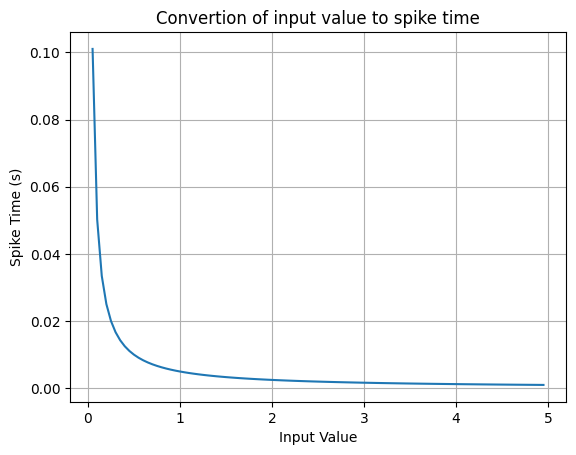

In [52]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5 with step 0.05
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel("Input Value")
plt.ylabel("Spike Time (s)")
plt.title("Convertion of input value to spike time")
plt.grid()
plt.show()

In [54]:
# Using `spikegen` to convert input features to latency-coded spikes
spike_data = spikegen.latency(data_it, num_steps=num_steps, tau=5, threshold=0.01)

The agruments include:
* `tau`: the membrane time constant (i.e. rise time). A higher `tau` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a close form solution. All values below this threshold are clipped and assigned to the final time step.

### 2.3.1 RASTER PLOT

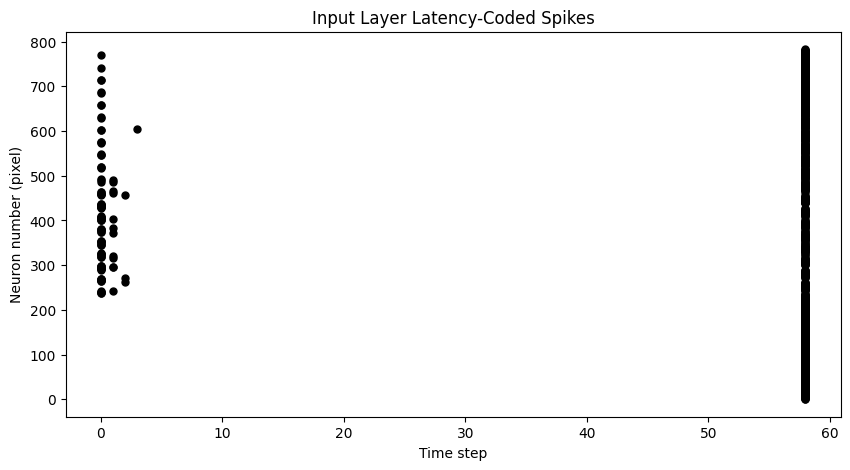

In [55]:
fig = plt.figure(facecolor='w', figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(data=spike_data[:,0].view(num_steps, -1), ax=ax, s=25, c="black")
plt.title("Input Layer Latency-Coded Spikes")
plt.xlabel("Time step")
plt.ylabel("Neuron number (pixel)")
plt.show()

The spike firing time vs the input current (i.e. pixel value) is logarithmic. The lack of diverse input values in MNIST (i.e. lack of midtone/ grayscale features) causes significant clustring in two areas of the plot. To overcome this, we can increase the `tau` value, which will increase the firing time of the spikes, or linearize the spike times relative to the input current by setting `linearize=True`. Although there is no physical basis for this model, it is useful for visualizing the data. Another option is to use the `clip` argument, which will clip the spike times to a maximum value.

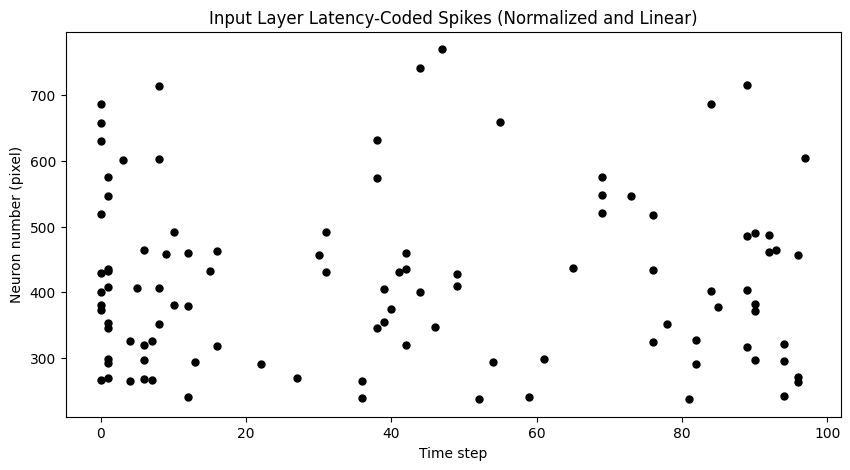

In [58]:
spike_data = spikegen.latency(data_it, num_steps=num_steps, tau=5, threshold=0.01, 
                              normalize=True, linear=True, clip=True)

fig = plt.figure(facecolor='w', figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(data=spike_data[:,0].view(num_steps, -1), ax=ax, s=25, c="black")
plt.title("Input Layer Latency-Coded Spikes (Normalized and Linear)")
plt.xlabel("Time step")
plt.ylabel("Neuron number (pixel)")
plt.show()

A major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation. The scenario above, shows just how sparse the spike train can be, especially when removing the background values.

### 2.3.2 ANIMATION

In [59]:
spike_data_sample = spike_data[:,0,0]
print(f"spike_data_sample shape: {spike_data_sample.shape}")

spike_data_sample shape: torch.Size([100, 28, 28])


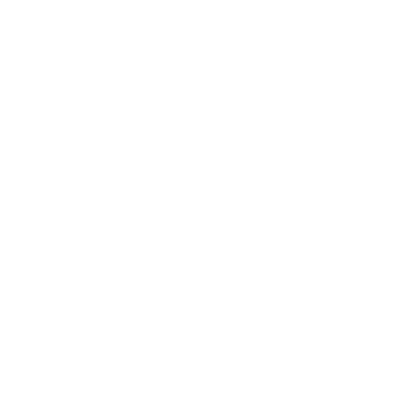

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
anim = splt.animator(spike_data_sample, fig, ax)
HTML(anim.to_html5_video())  # Display the animation in Jupyter Notebook

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur. Index into the corresponding target value to check its value.

## 2.3 DELTA MODULATION
The retina encodes changes in the visual scene: it will only proess information when there is something new to process. If there is no change in the field of view, then the photoreceptors are less prone to firing. That is to say: **biology is event-driven**. Neurons thrive on change.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series as inpu. It takes the difference between each subsequent feature across all time steps. If the difference is bot *positive* and *greater than* the threshold $V_{thr}$ a spike is generated. In the same way, if the difference is *negative* and *less than* the threshold $V_{thr}$ a spike is generated. 

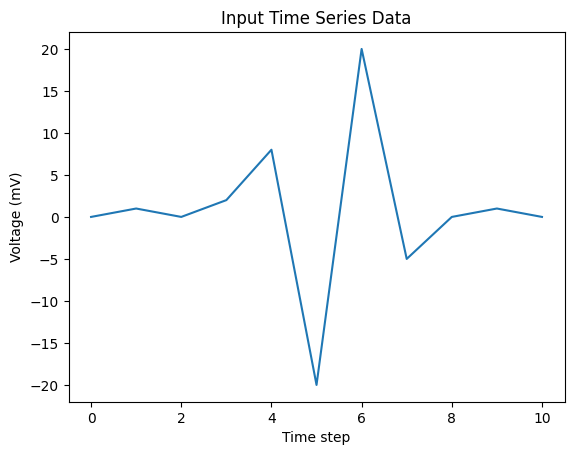

In [61]:
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0]) # a time series of input values

# plot the tensor
plt.plot(data)

plt.title("Input Time Series Data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

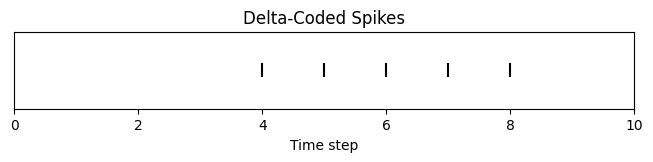

Delta-coded spikes: tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


In [63]:
# convert the time series data to delta-coded spikes
spike_data = spikegen.delta(data, threshold=4, off_spike=True)  # threshold is set to 4 arbitrarily

# Plot the delta-coded spikes
fig = plt.figure(facecolor='w', figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot
splt.raster(spike_data, ax, c="black", s=100, marker="|")

plt.title("Delta-Coded Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data) - 1)
plt.show()

print(f"Delta-coded spikes: {spike_data}")

Everytime the absolute change in the input exceeds the threshold, a spike is generated. For every time step, the output spike train can have any of **3 values: [-1,0,1]** representing a negative change, no change, or positive change respectively.

Event cameras uses delta modulation to encode the visual scene. 